# Terrorism detection and estimations
Terrorism is another interesting application of Machine Learning for crime detection and prevention. The topic is really vast therefore we're going to talk about some techniques and give some references for the details.

Small spoiler: terrorists tend to hide their tracks so as to make themselves nearly invisible. There are only a couple actions they can't help doing. Those features alone provide little to no useful information thus *data mining* can help establishing meaningful relationships.

We'll divide this notebook into 3 parts:

1. Estimating the number of victims done by terrorists
2. Identifying terroristic fingerprints
3. Identifying terrorists

## Red Brigade Movement and Volterra formula

According to Wikipedia, the **Lotka–Volterra** equations, also known as the **predator–prey equations**, are a pair of *first-order nonlinear differential equations*, frequently used to describe the dynamics of biological systems in which two species interact, one as a *predator* and the other as *prey*. (Bold and italics are ours).

The solution for the Lotka-Volterra equations is usually the so-called logistic curve.
$$f(x) = \frac{L}{1 + e^{-k(x - x_0)}}$$

Where:
* e = the natural logarithm base (also known as Euler's number),
* $x_0$ = the x-value of the sigmoid's midpoint,
* L = the curve's maximum value, and
* k = the steepness of the curve.

Basically it is nothing but a dilatated and translated sigmoid function: $$ g(x) = \frac{1}{1+e^{-x}} $$


Mr Marchetti noticed how this formula could work and fit fairly well even in radically differents contexts such as the artistic vérve of William Shakespeare and Sandro Botticelli, the rate of automobile population in Italy and the cumulative number of murderers done by Red Brigades members.

In [3]:
%matplotlib inline

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from math import exp
import numpy as np
import matplotlib.pyplot as plt

def logistic_function(L, k, x_0, xmin, xmax, ticks=False, plot=True):
    logit = np.vectorize(lambda x: L/(1+exp(-k*(x-x_0))))
    if plot:
        X_test = np.linspace(xmin, xmax)
        y = logit(X_test)
        if ticks:
            %matplotlib notebook
            plt.xticks(np.unique(np.ceil(X_test)), rotation='vertical')
        plt.plot(X_test, y, color='red')
    return logit

a = interact(logistic_function, L = (0.5,5.), k = (0.05, 1), x_0 = (-5.,5.),
             xmin=-20, xmax = +20)

interactive(children=(FloatSlider(value=2.75, description='L', max=5.0, min=0.5), FloatSlider(value=0.525, description='k', max=1.0, min=0.05), FloatSlider(value=0.0, description='x_0', max=5.0, min=-5.0), IntSlider(value=-20, description='xmin', max=20, min=-60), IntSlider(value=20, description='xmax', max=60, min=-20), Checkbox(value=False, description='ticks'), Checkbox(value=True, description='plot'), Output()), _dom_classes=('widget-interact',))

We want to estimate the number of attacks made by red brigadists during the "lead years" in Italy during the period 1971-1975 and we want to predict the **cumulative** number of attacks and the end of the activity of the terrorist group. By cumulative we mean the sum of the attacks happened from the first year of the activity until the current time.

| Year | No of attacks (cumulative) |
|------|----------------------------|
| 1971 | 5                          |
| 1972 | 11                         |
| 1973 | 19                         |
| 1974 | 34                         |
| 1975 | 69 

Since the solution is: $$f(t) = \frac{250}{1+e^{-0.75(t - 1976.1)}}$$

we can try the following prediction

<IPython.core.display.Javascript object>


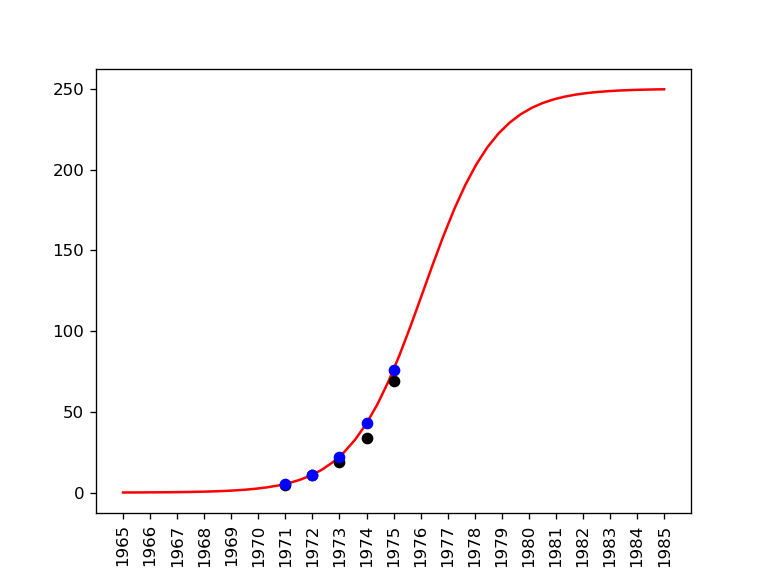

(array([  5.,  11.,  22.,  42.,  76.]), array([  5.,  11.,  19.,  34.,  69.]))

In [2]:
%matplotlib notebook
regression = logistic_function(L=250, k=0.75, x_0 = 1976.1,
                  xmin=1965, xmax = +1985,
                  ticks=True, plot=True)

dataset = np.array([
    [1971, 5],
    [1972, 11],
    [1973, 19],
    [1974, 34],
    [1975, 69]
])
features = dataset[...,0].ravel()
targets = dataset[...,1].ravel()
plt.plot(features, targets, 'ko')
plt.plot(features, regression(features), 'bo')
np.trunc(regression(features)), np.trunc(targets) # same formatting

Good! Now we can estimate the number of attacks in any year we like. Let's consider 1976

In [ ]:
np.trunc(regression(np.array(1976)))

And actually the total number of assassination attempts in 1976 is 122. The prediction looked really accurate.

Now let's consider the *number of death per year* caused by the Red Brigades. It's simply $H(t) = f(t) - f(t-1) \approx \frac{f(t) - f(t-\delta)}{\delta} = f'(t)$, by letting $\delta \rightarrow 0$

That is, we consider the derivative of the logistic function.
So, **the derivative of this function corresponds to the number of victims per year**.
Its full expression is:

$$\frac{kLe^{-k(x+x_0)}}{(1+e^{-k(x-x_0)})^2}$$

When $x = x_0 \quad f'$ reaches its global maximum. In fact the assassination attempts reached the highest score during the period 1976-1977. We also see a horizontal asymptote when $x \geq 1985 $, when the Red Brigades halted their criminal activity.

Why did they stop? It isn't ours to understand the underlying reasons behind this curve, what we only have to care know is that the logistic model turned out predicting fairly well.

If you are curious try it yourself with different datasets like Cosa Nostra's carnages. Other ideas are Ku Klux Clan, OLP, Jack the ripper.

# Sentiment analysis

Although the field of Sentiment Analysis is extremely vast and complex \[2\], the common starting point is data mining. Almost any research paper dedicated to Sentiment Analysis makes use of Twitter to get an uninterrupted flow of messages (the current rates can be read in (Azizan et al., 2017)), thanks to both its set of API \[5\] and satellite "cleansing services" to strip @tags, \#hashtags etc. Broadly speaking tweets are difficult to analyse whereas Facebook posts can be easier to tackle, both for humans and machines.

The correlation between SA and terrorism is proved by terrorists' tendence to diffuse proselytism of false, violent beliefs, thus intrinsecally full of hate words and expression.

Things are not so easy. 
* Negative reviews, jokes, sarchasm and complain result as negative as terrorist text messages.
* Outrageous posts may be isolated cases and have no link to previous nefarious messages.

Effectively defeating online terrorism is a hard task when it comes to analysing single posts which may seem ambiguous for humans too.

**N.B. We're not going to be exhaustive.**

## Old-schooler: Naïve Bayes Classification (basically your spam detector)


Given a list of words we want to give the sentence a class like "\{happy, sad, angry,...\}"; terrorist messages may have a tendency to be particolarly fearsome and angry besides having some keyword such as caliph and Allah.

Let us introduce some notation:

$P(C_i)$ is the probability (aka the relative frequency for our purpuoses) of a certain message whereas $P(w_i)$ is the probability of a certain word $w_i$. In order to calculate $P(w_i)$ we need a good distribution model. A lookup frequency table may be fine however different distribution functions can work better in other contexts.

Let $W = \{w_1, w_2, ..., w_n\}$

Thanks to Bayes theorem we can say that

$$ P(C_i|W) = \frac{P(W|C_i)P(C_i)}{P(W)}$$

The "naive" assumption is that all the words used in this sentence are indipendent from each other so $P(W) = P(w_1)P(w_2)\cdots P(w_n)$ so the problem is a piece of cake:

$$P(C_i | W) = \frac{P(W|C_i)P(C_i)}{P(W)} = \frac{P(w_1|C_i)P(w_2|C_i)\cdots P(w_n|C_i)\cdot P(C_i)}{P(w_1)P(w_2)\cdots P(w_n)}$$

Then iterate for any class and take for good the class with the highest probability (*Maximum A Posteriori*)

That method has lots of drawbacks. Messages like "I feel bad when it rains" and "new therapy overcomes depression" may result in the same emotion score. Besides, there's no way to establish any relationships between messages and contextualize tweets. The accuracy is really low. Of course we're excluding the noise coming from tags and mispelled words.

An improvement suggested in \[3\] is collecting all the tweets from a single person or a group of interesting people, cleaning them (stripping tags, correcting mispelled words etc.) and classifying them together. The training step must respect the posts cronology.

## Artificial Neural Networks: A Highway to Hell

Neural networks are now able to process natural language (see NLP). Determine the structure of the sentence is a big improvement and could be used in pair with Bayesian score, especially when it comes to studying not only certain words but patterns like pairs, triples and in general the finding of useful n-grams. Example: *not* + adjective is its opposite. If a sentence ends with an exclamation point has higher probability to be sarchastic etc.

What neural networks models can be used?

* **Multi-layer perceptron** or **MLP**: it can be able to take multiple features in account at the same time. However the classification does not consider the "history" of the user. The accuracy is usually quite low. Besides, training may be really slow and require a huge dataset in the majority of cases so as to reach a discrete  performance. Besides *there's no memory* (i.e. provided the same input over time the classification will always be the same). Although this property is not really related to sentiment analysis it may be desirable for terrorism detection.

* **Recurrent neural network** or **RNN**: it is a class of artificial neural network where connections between nodes form a directed graph along a sequence. This allows it to exhibit dynamic temporal behavior for a time sequence (Wikipedia). The key idea is the ability to fully track recurrent traits and, to some extent, implement a rudimental memory. The main drawbacks however are the training period - usually longer than in MLPs - and the memory lenght, usually not as long as we may need

* **Long short-term memory network** or **LSTM**: can implement an arbitrary long memory. The core idea is to have some special cells for **input**, **output**, **storage** and **forget** stages or "gates". The layers of the LSTM are "conventional" neural networks, even RNNs.

This topic is more deeply discussed in \[6\] and \[7\]

# References

\[1\]: Marchetti, C., On Time and Crime: A Quantitative Analysis of the Time Pattern of Social and Criminal Activities, IIASA WP-85-084 (1985)

\[2\]: https://scholar.google.it/scholar?hl=en&as_sdt=0%2C5&q=sentiment+analysis+terrorism&btnG= : about 102,000 results so far

\[3\]: Azizan, S. A., Aziz, I. A.: Terrorism Detection Based on Sentiment Analysis Using Machine Learning, Universiti Teknologi Petronas Bandar Seri Iskandar, Perak, Malaysia (2017)

\[4\]: Hassan, A., Korashy, H., Medhat, W.: Sentiment analysis algorithms and applications - a survey. Ain Shams Eng. J. 5, 1093–1113 (2014)

\[5\]: https://developer.twitter.com/en/docs/api-reference-index.html

\[6\]: Kouloumpis, E., Wilson, T., Moore, J.: Twitter Sentiment analysis: The Good the Bad and the OMG!, Fifth International aaai (2009)

\[7\]: Chung, J., Gulcehre, C., Cho, K., Bengio, Y. Empirical Evaluation of Gated Recurrent Neural Networks on Sequence Modeling